# Analysis


1. Target --> Counter underfitting from Net_A
2. Results --> Params: 7,544, Droputout value = 0, StepLR changes every 5 epochs
3. Analysis --> Consistently achieves 99.4% accuracy for test loss, but still overfitting.

Next we will try to slightly increase the number of parameters to reach the 8k mark.

In [ ]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/ERA - Phase I/Session 7/

/content/gdrive/My Drive/ERA - Phase I/Session 7


In [ ]:
!ls

data  model.py	__pycache__  README.md	S7_A.ipynb  S7_B.ipynb	utils.py


# Imports

In [ ]:
from model import Net_B

In [ ]:
import utils as utils

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Dataset, Transforms

In [ ]:
device, use_cuda = utils.device()
print(f'CUDA Avialble? {use_cuda}')

CUDA Avialble? True


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
batch_size = 64
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

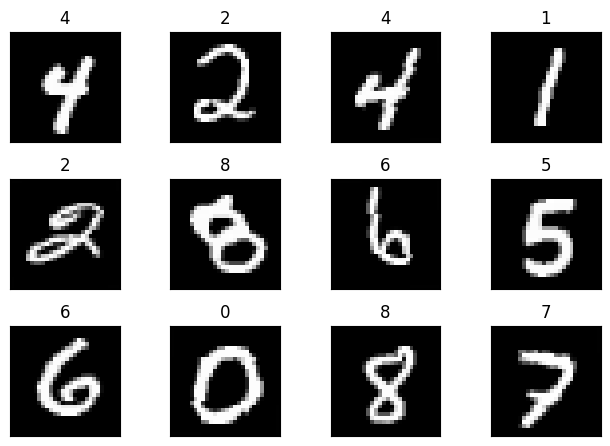

In [ ]:
batch_data, batch_label = next(iter(train_loader))
utils.show_examples_dataset(batch_data, batch_label)

# Model

In [ ]:
model = Net_B().to(device)
utils.show_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

# Training

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0220 Batch_id=937 Accuracy=91.53: 100%|██████████| 938/938 [00:29<00:00, 31.67it/s]


Test set: Average loss: 0.0613, Accuracy: 9824/10000 (98.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0315 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:25<00:00, 36.68it/s]


Test set: Average loss: 0.0360, Accuracy: 9895/10000 (98.95%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0421 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:26<00:00, 35.76it/s]


Test set: Average loss: 0.0359, Accuracy: 9892/10000 (98.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0278 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:26<00:00, 35.19it/s]


Test set: Average loss: 0.0316, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0268 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:26<00:00, 34.85it/s]


Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 6


Train: Loss=0.1015 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:26<00:00, 35.40it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 7


Train: Loss=0.0979 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:26<00:00, 34.87it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 8


Train: Loss=0.0330 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:26<00:00, 35.00it/s]


Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 9


Train: Loss=0.0023 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:27<00:00, 34.63it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 10


Train: Loss=0.2136 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:26<00:00, 34.82it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 11


Train: Loss=0.0045 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:27<00:00, 34.46it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 12


Train: Loss=0.0577 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:27<00:00, 34.62it/s]


Test set: Average loss: 0.0202, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 13


Train: Loss=0.0011 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:27<00:00, 34.49it/s]


Test set: Average loss: 0.0188, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 14


Train: Loss=0.1631 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:26<00:00, 34.85it/s]


Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 15


Train: Loss=0.0015 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:27<00:00, 34.62it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.2500e-03.


# Results

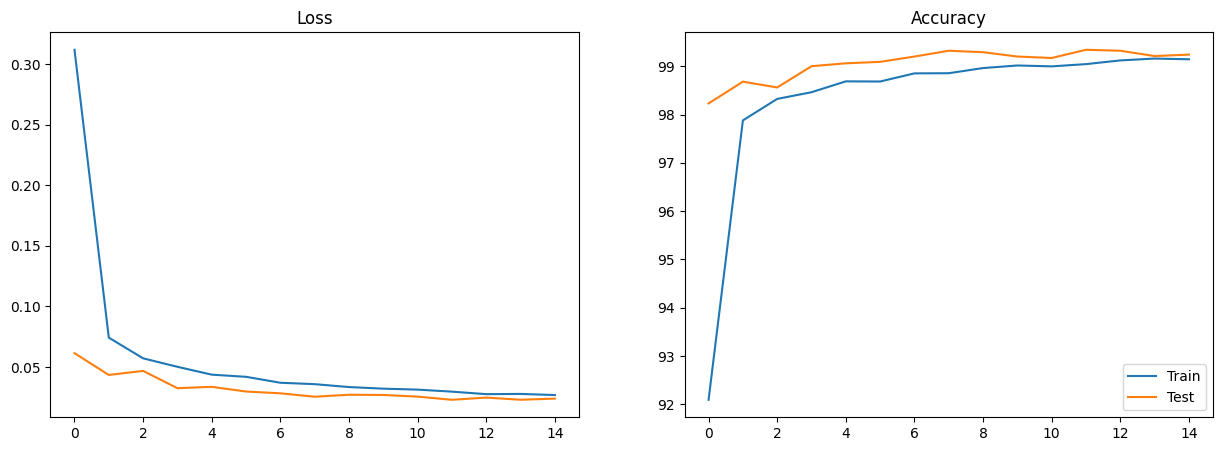

In [ ]:
utils.plot_loss_accuracy([train_losses, test_losses, train_acc, test_acc])